# TIME SERIES FORECASTING OF PROJECT TWEETS BIG DATA PROCESSED WITH SPARK AND STORED IN MONGODB

# Dataset
The dataste is a large dataset gleaned from the twitter API that is called ProjectTweets.csv.

This dataset contains 1,600,000 tweets extracted using the twitter api. 


Content
It contains the following 5 fields:
- ids: The id of the tweet (eg. 4587)
- date: the date of the tweet (eg. Sat May 16 23:58:44 UTC 2009)
- flag: The query (eg. lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (eg. bobthebuilder)
- text: the text of the tweet (eg. Lyx is cool)

## Install all Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, lower, regexp_replace, trim, split, udf
from pyspark.sql.functions import isnull, to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StringType, TimestampType
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
# Creating a pyspark session connecting to mongodb
uri = "mongodb://172.17.0.8:27017/Diana_Project_mongo.Tweets"

spark = SparkSession.builder.appName("Write into MongoDB")\
    .config("spark.mongodb.input.uri", uri)\
    .config("spark.mongodb.output.uri", uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

In [3]:
spark

# Step one: Writing Data into MongoDB using Apache Spark

## Loading data from local machine to SParkSQL

In [4]:
# Set legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Define the schema for the csv file 
schema = StructType().add("_c0", StringType(), True).add("_c1", StringType(), True).add("_c2", StringType(), True).add("_c3", StringType(), True).add("_c4", StringType(), True).add("_c5", StringType(), True)

# Read the CSV into a DataFrame called df
df = spark.read.format("csv").option("header", False).schema(schema).load("file:///home/jovyan/Diana/ProjectTweets.csv")

# Rename the headers
df = df.withColumnRenamed("_c0", "PRIMARY KEY").withColumnRenamed("_c1", "ID").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

# Convert string date to TimestampType
df = df.withColumn("date", to_timestamp(df["date"], "EEE MMM dd HH:mm:ss zzzz yyyy"))

# Print schema
df.printSchema()

# Show DataFrame
df.show(5)


root
 |-- PRIMARY KEY: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+-----------+----------+-------------------+--------+---------------+--------------------+
|PRIMARY KEY|        ID|               date|    flag|           user|                text|
+-----------+----------+-------------------+--------+---------------+--------------------+
|          0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|          1|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|          2|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|          3|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|          4|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
+-----------+----------+------------------

## Write data from spark to MongoDB

In [5]:
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

# Step Two: Read the Project Tweets data from MongoDB using Spark

In [6]:
from_mongo = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
print((from_mongo.count(), len(from_mongo.columns)))
from_mongo.printSchema()
from_mongo.show(5)

(1600000, 7)
root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|           user|
+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+
|1551363506|     816210|{66364d27fdf41a68...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|  prosario_2000|
|1551363569|     816211|{66364d27fdf41a68...|2009-04-18 15:51:39|NO_QUERY|@Boy_Kill_Boy Nop...|Chelsea_Volturi|
|1551363682|     816212|{66364d27fdf41a68...|2009-04-18 15:51:41|NO_QUERY|@marty0518 Someti...|askbillmitchell|
|155136375

# EXPLORATORY DATA ANALYSIS

# Checking for Duplicates (based on ID, user and text) and Missing data

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum  # Import the 'col' and 'sum' functions

# Initialize Spark Session
spark = SparkSession.builder.appName("Duplicate and Missing Data Check").getOrCreate()

# Define the columns to check for duplicates and missing values
columns_to_check = ['PRIMARY KEY','ID', 'user', 'text']

# Create a pipeline to check for duplicates and missing values
pipeline_df = from_mongo

# Step 1: Remove duplicate records based on specified columns
pipeline_df = pipeline_df.dropDuplicates(subset=columns_to_check)

# Step 2: Check for missing values
missing_counts = pipeline_df.select([col(c).isNull().cast("int").alias(c) for c in columns_to_check]).agg(*[sum(c).alias(c) for c in columns_to_check]).collect()[0]

# Print the results
print("Number of duplicate records removed:", df.count() - pipeline_df.count())

print("Missing value counts:")
for col_name, missing_count in zip(columns_to_check, missing_counts):
    print(col_name, missing_count)

Number of duplicate records removed: 0
Missing value counts:
PRIMARY KEY 0
ID 0
user 0
text 0


In [8]:
#Checking for duplicates in ID and user name
# Count the number of rows before removing duplicates
count_before = from_mongo.count()

# Remove duplicates
df_no_duplicates = from_mongo.dropDuplicates()

# Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

# Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed: {num_duplicates}")

Number of duplicate rows removed: 0


In [9]:
# Count the number of rows before removing duplicates
count_before = from_mongo.count()

# Remove duplicates based on a specific column
df_no_duplicates = from_mongo.dropDuplicates(subset=['user'])

# Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

# Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed based on user: {num_duplicates}")

Number of duplicate rows removed based on user: 940225


# Summary Statistics

In [10]:
#Summary Statistics
from_mongo.describe().show()

+-------+--------------------+-----------------+--------+--------------------+--------------------+
|summary|                  ID|      PRIMARY KEY|    flag|                text|                user|
+-------+--------------------+-----------------+--------+--------------------+--------------------+
|  count|             1600000|          1600000| 1600000|             1600000|             1600000|
|   mean|1.9988175522956276E9|         799999.5|    NULL|                NULL| 4.325887521835714E9|
| stddev| 1.935760736226746E8|461880.3596892475|    NULL|                NULL|5.162733218454887...|
|    min|          1467810369|                0|NO_QUERY|                 ...|        000catnap000|
|    max|          2329205794|           999999|NO_QUERY|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|          zzzzeus111|
+-------+--------------------+-----------------+--------+--------------------+--------------------+



# EXTRACTING TIME COMPONENTS

In [11]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


#Initialize Spark Session
spark = SparkSession.builder.appName("DateTime Visualization").getOrCreate()

# Extract relevant time components including hours, minutes, and seconds
df = from_mongo.withColumn("year", year("date")).withColumn("month", month("date")).withColumn("day", dayofmonth("date")).withColumn("hour", hour("date")).withColumn("minute", minute("date")).withColumn("second", second("date"))

# Aggregate data
time_series_data = df.groupBy("date","year", "month", "day", "hour", "minute", "second").count().orderBy("year", "month", "day", "hour", "minute", "second")

In [12]:
#View the df DataFrame after extracting time components
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|           user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|1551363506|     816210|{66364d27fdf41a68...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|  prosario_2000|2009|    4| 18|  15|    51|    40|
|1551363569|     816211|{66364d27fdf41a68...|2009-04-18 15:51:39|NO_QUERY|@Boy_Kill_Boy Nop...|Chelsea_Volturi|2009|    4| 18|  15|    51|    39|
|1551363682|     816212|{66364d27fdf41a68...|2009-04-18 15:51:41|NO_QUERY|@marty0518 Someti...|askbillmitchell|2009|    4| 18|  15|    51|    41|
|1551363752|     816213|{66364d27fdf41a68...|2009-04-18 15:51:41|NO_QUERY|so i guesss im no...|       kendiixd|2009|    4| 1

In [13]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [14]:
from pyspark.sql.functions import count

# Group by the year variable and count the occurrences
year_counts = df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

# Show the tabulated counts
year_counts.show()

+----+-------+
|year|  count|
+----+-------+
|2009|1600000|
+----+-------+



In [15]:
from pyspark.sql.functions import count

# Group by the month variable and count the occurrences
month_counts = df.groupBy("month").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
month_counts.show()

+-----+------+
|month| count|
+-----+------+
|    4|100025|
|    5|559073|
|    6|940902|
+-----+------+



In [16]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
day_counts = df.groupBy("day").agg(count("*").alias("count")).orderBy("day")

# Show the tabulated counts
day_counts.show()

+---+------+
|day| count|
+---+------+
|  1| 95449|
|  2|108872|
|  3| 86707|
|  4| 32938|
|  5| 34735|
|  6|104793|
|  7|132564|
|  8| 18566|
| 10| 31551|
| 11|  6217|
| 12|  4186|
| 14| 22026|
| 15| 83309|
| 16| 87524|
| 17| 85236|
| 18|105040|
| 19| 75612|
| 20| 64029|
| 21| 41782|
| 22| 49519|
+---+------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
day_counts = df.groupBy("month","day").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
day_counts.show()

+-----+---+------+
|month|day| count|
+-----+---+------+
|    4|  7| 20671|
|    4| 18| 17154|
|    4| 20| 18447|
|    4| 21| 11105|
|    4| 19| 32648|
|    5|  4| 28300|
|    5|  2| 31096|
|    5|  3| 26568|
|    5| 22| 41206|
|    5| 24|   169|
|    5| 17| 41205|
|    5| 12|  4186|
|    5| 10| 31551|
|    5| 29| 60227|
|    5| 18| 44564|
|    5| 27| 11619|
|    5| 11|  6217|
|    5| 14| 21526|
|    5| 25|   169|
|    5| 30|104484|
+-----+---+------+
only showing top 20 rows



In [18]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
ID_counts = df.groupBy("ID").agg(count("*").alias("count")).orderBy("ID")

# Show the tabulated counts
ID_counts.show()

+----------+-----+
|        ID|count|
+----------+-----+
|1467810369|    1|
|1467810672|    1|
|1467810917|    1|
|1467811184|    1|
|1467811193|    1|
|1467811372|    1|
|1467811592|    1|
|1467811594|    1|
|1467811795|    1|
|1467812025|    1|
|1467812416|    1|
|1467812579|    1|
|1467812723|    1|
|1467812771|    1|
|1467812784|    1|
|1467812799|    1|
|1467812964|    1|
|1467813137|    1|
|1467813579|    1|
|1467813782|    1|
+----------+-----+
only showing top 20 rows



In [19]:
time_series_data.show(5)

+-------------------+----+-----+---+----+------+------+-----+
|               date|year|month|day|hour|minute|second|count|
+-------------------+----+-----+---+----+------+------+-----+
|2009-04-07 05:19:45|2009|    4|  7|   5|    19|    45|    1|
|2009-04-07 05:19:49|2009|    4|  7|   5|    19|    49|    1|
|2009-04-07 05:19:53|2009|    4|  7|   5|    19|    53|    1|
|2009-04-07 05:19:57|2009|    4|  7|   5|    19|    57|    2|
|2009-04-07 05:20:00|2009|    4|  7|   5|    20|     0|    1|
+-------------------+----+-----+---+----+------+------+-----+
only showing top 5 rows



In [20]:
type(time_series_data)

pyspark.sql.dataframe.DataFrame

In [21]:
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|           user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|1551363506|     816210|{66364d27fdf41a68...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|  prosario_2000|2009|    4| 18|  15|    51|    40|
|1551363569|     816211|{66364d27fdf41a68...|2009-04-18 15:51:39|NO_QUERY|@Boy_Kill_Boy Nop...|Chelsea_Volturi|2009|    4| 18|  15|    51|    39|
|1551363682|     816212|{66364d27fdf41a68...|2009-04-18 15:51:41|NO_QUERY|@marty0518 Someti...|askbillmitchell|2009|    4| 18|  15|    51|    41|
|1551363752|     816213|{66364d27fdf41a68...|2009-04-18 15:51:41|NO_QUERY|so i guesss im no...|       kendiixd|2009|    4| 1

In [22]:
type(df)

pyspark.sql.dataframe.DataFrame

In [23]:
df = df.drop("_id", "ID", "PRIMARY KEY")

In [31]:
df.write.csv("tweeter_data.csv")

In [34]:
# Write the DataFrame to JSON format
df.write.json("tweeterdata.json")

## save the spark dataframe as a pandas

In [55]:
pandas_df = pd.read_csv('pandas_df.csv')

In [60]:
pandas_df.head()

,date,text,user
0,2009-04-18 08:51:40,user i hope you are having a great day,prosario_2000
1,2009-04-18 08:51:39,user nope just bored well say that most of the...,Chelsea_Volturi
2,2009-04-18 08:51:41,user sometimes and just a little cryptic lol i...,askbillmitchell
3,2009-04-18 08:51:41,so i guesss im not in coolifornia anymore how ...,kendiixd
4,2009-04-18 08:51:42,user i do that too but right now its the radia...,ladycalypso


In [57]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   date    1600000 non-null  object
 1   text    1600000 non-null  object
 2   user    1600000 non-null  object
dtypes: object(3)
memory usage: 36.6+ MB


In [63]:
pandas_df['date'] = pd.to_datetime(pandas_df['date'])
pandas_df = pandas_df.sort_values(by='date')
pandas_df

,date,text,user
2048,2009-04-06 22:19:45,user http awww thats a bummer you shoulda go...,_TheSpecialOne_
2049,2009-04-06 22:19:49,is upset that he cant update his facebook by t...,scotthamilton
2050,2009-04-06 22:19:53,user i dived many times for the ball managed t...,mattycus
2051,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,ElleCTF
2052,2009-04-06 22:19:57,user no its not behaving at all im mad why am ...,Karoli
...,...,...,...
1560787,2009-06-25 10:28:28,tried to get the mutant fawkes to follow me bu...,360cookie
1560791,2009-06-25 10:28:28,gmail is down,bigenya
1560796,2009-06-25 10:28:30,user sounds like a rival is flagging your ads ...,davidlmulder
1560794,2009-06-25 10:28:30,rest in peace farrah so sad,LeeLHoke


# Plotting a  WordCloud 

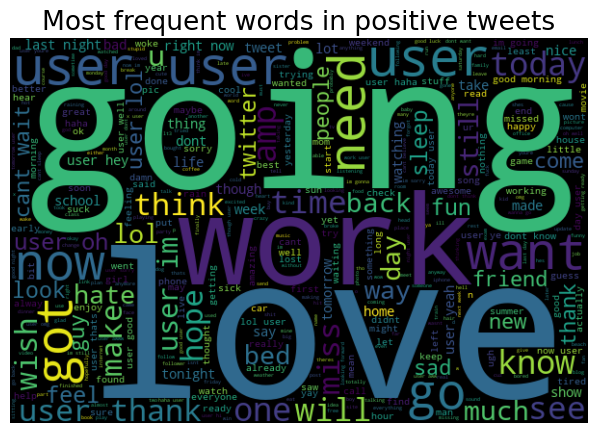

In [ ]:
plt.figure(figsize=(10,5), facecolor='None')

text = ' '.join([word for word in pandas_df['text']])
wordcloud = WordCloud(max_words=500, width=600, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in tweets', fontsize=19)
plt.show()

## Number of Words per tweeter
using a lambda function , it is possible to count the words in each tweeter.

In [65]:
pandas_df['number_of_words'] = pandas_df.text.apply(lambda x: len(x.split()))
pandas_df.head()

,date,text,user,number_of_words
2048,2009-04-06 22:19:45,user http awww thats a bummer you shoulda go...,_TheSpecialOne_,18
2049,2009-04-06 22:19:49,is upset that he cant update his facebook by t...,scotthamilton,21
2050,2009-04-06 22:19:53,user i dived many times for the ball managed t...,mattycus,18
2051,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,ElleCTF,10
2052,2009-04-06 22:19:57,user no its not behaving at all im mad why am ...,Karoli,21


### Plotting the lowest, median and biggest Word count of the tweeter

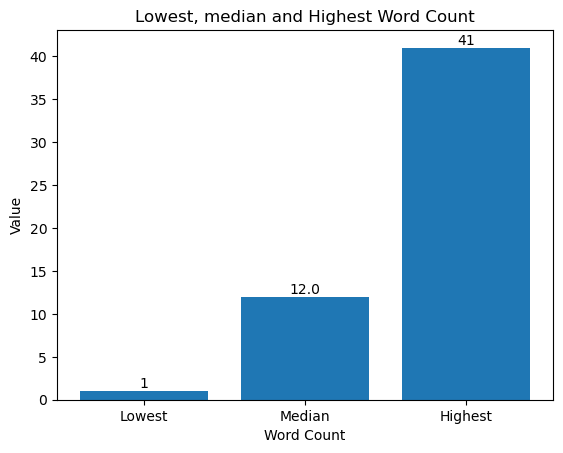

In [66]:
number_of_words = pandas_df['number_of_words']
lowest_value = number_of_words.min()
median_value =number_of_words.median()
highest_value = number_of_words.max()


plt.bar(['Lowest', 'Median', 'Highest'], [lowest_value, median_value, highest_value])

# Annotating the bars with their values
plt.text(0, lowest_value, str(lowest_value), ha='center', va='bottom')
plt.text(1, median_value, str(median_value), ha='center', va='bottom')
plt.text(2, highest_value, str(highest_value), ha='center', va='bottom')

plt.xlabel('Word Count')
plt.ylabel('Value')
plt.title('Lowest, median and Highest Word Count')
plt.show()


For sentiment analysis, TextBlob is a commonly used library, TextBlob calculates polarity to determine sentiment. However, its accuracy is considered moderate. For more precise accuracy, there are machine learning techniques designed specifically for sentiment analysis. 
For example:"

**VADER (Valence Aware Dictionary and Sentiment Reasoner):** 

    Is specifically designed for analyzing sentiments in social media text and has been trained on such data.
    VADER uses a combination of a sentiment lexicon (a predefined list of words with associated sentiment scores) and a set of grammatical rules to determine the sentiment of a text.
    
    * a positive sentiment, compound ≥ 0.05.
    * a negative sentiment, compound ≤ -0.05.
    * a neutral sentiment, the compound is between -0.05, 0.05


**Bag of Words (BoW) vectorization approach:** 

    It is another technique commonly used in sentiment analysis and text classification tasks.

# Applaying VADER 

In [23]:
# Download the lexicon
nltk.download("vader_lexicon") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# function label_output labels the output based on compound
def label_output(compound):
  
  polarity = "neutral"

  if(compound['compound'] >= 0.05):
    polarity = "positive"

  elif(compound['compound'] <= -0.05):
    polarity = "negative"

  return polarity


# Function sentment analyzes the text and returns the compound
def sentiment(text):
  
  compound =  sent_analyzer.polarity_scores(text)
  return label_output(compound)


### Aplying  Vader Sentiment

In [68]:
pandas_df["sentiment"] = pandas_df["text"].apply(sentiment)
pandas_df.head()

,date,text,user,number_of_words,sentiment
2048,2009-04-06 22:19:45,user http awww thats a bummer you shoulda go...,_TheSpecialOne_,18,negative
2049,2009-04-06 22:19:49,is upset that he cant update his facebook by t...,scotthamilton,21,negative
2050,2009-04-06 22:19:53,user i dived many times for the ball managed t...,mattycus,18,positive
2051,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,ElleCTF,10,negative
2052,2009-04-06 22:19:57,user no its not behaving at all im mad why am ...,Karoli,21,negative


# Plotting Sentiments

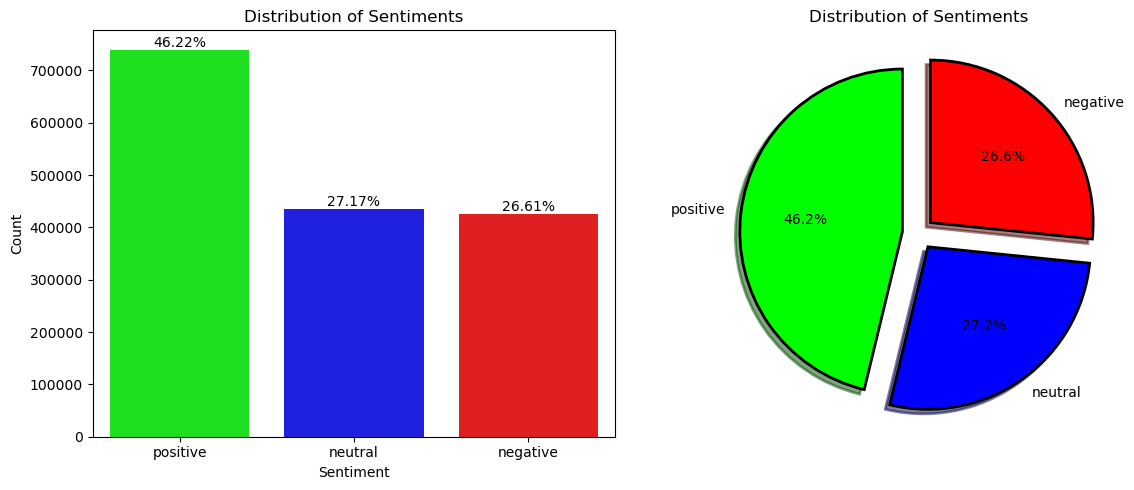

In [16]:
# Analyzing the distribution of sentiments
pie_vader = pandas_df['sentiment'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Defining custom color palettes
colors = {
    'negative': "#FF0000",  # Red for Negative sentiment
    'neutral': "#0000FF",   # Blue for Neutral sentiment
    'positive': "#00FF00"  # Green for Positive sentiment
}

# Plotting the distribution of sentiments 
sent_dub = sns.barplot(x=pie_vader.index, y=pie_vader.values, ax=axes[0], palette=colors)

# Calculating percentages of each sentiment
total_values = sum(pie_vader.values)
for i, v in enumerate(pie_vader.values):
    percentage = round(v / total_values * 100, 2)
    axes[0].text(i, v + 1, f"{percentage}%", ha='center', va='bottom', color='black')

axes[0].set_title('Distribution of Sentiments')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

pie_colors = ("#00FF00", "#0000FF", "#FF0000")
wp = {'linewidth':2, 'edgecolor':"black"}
explode = (0.1,0.1,0.1)
pie_vader.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = pie_colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
axes[1].set_title('Distribution of Sentiments')

plt.tight_layout()
plt.show()

# Grouping sentiments 

For time series analysis, it is necessary to group the sentiments by a regular timestamp, daily basis, and as a sentment, the mode (the most frequent) will be used.

In [69]:
daily_sentiment = pandas_df.groupby(pandas_df['date'].dt.date)['sentiment'].value_counts().unstack(fill_value=0).reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

daily_sentiment.head(5)

sentiment,date,negative,neutral,positive
0,2009-04-06,879,917,1564
1,2009-04-07,4200,4844,8267
2,2009-04-17,695,801,1588
3,2009-04-18,5018,6015,10721
4,2009-04-19,6187,7685,13597


### Aparently , there are some gaps on days,  plotting a scatter plot its easy to verify

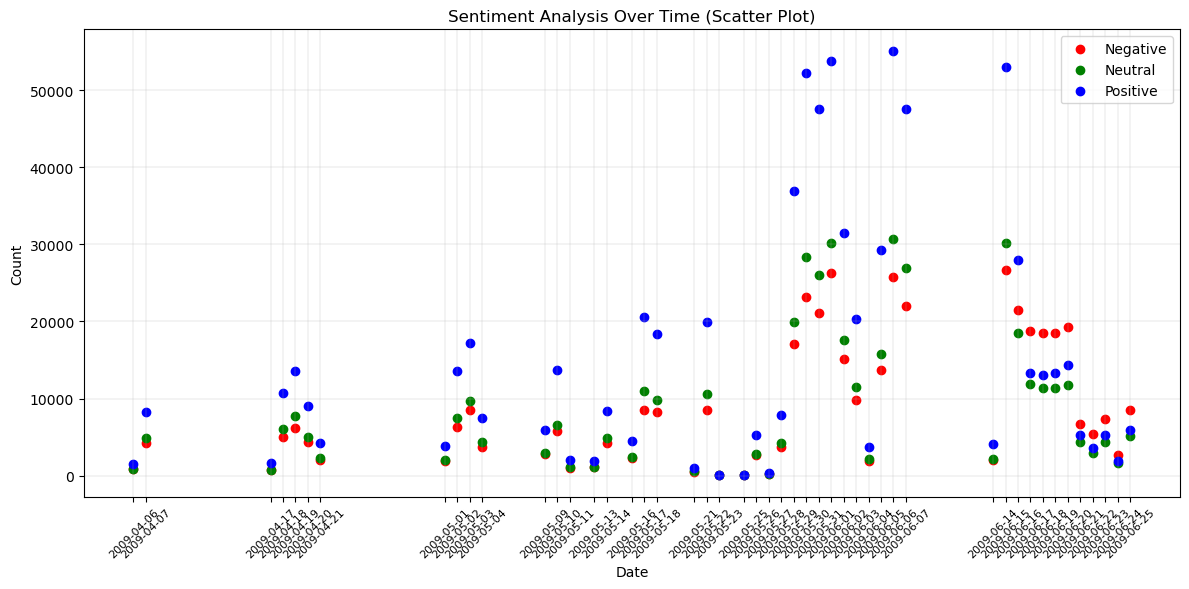

In [70]:
# Plotting a ScatterPlot 

plt.figure(figsize=(12, 6))
plt.scatter(daily_sentiment['date'], daily_sentiment['negative'], label='Negative', color='red')
plt.scatter(daily_sentiment['date'], daily_sentiment['neutral'], label='Neutral', color='green')
plt.scatter(daily_sentiment['date'], daily_sentiment['positive'], label='Positive', color='blue')
plt.xticks(daily_sentiment['date'],  rotation=45,fontsize=8) 
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Analysis Over Time (Scatter Plot)')
plt.grid(True, linewidth=0.2)
plt.tight_layout()
plt.legend()
plt.show()


***Insight***

it is possible to observe that the dataset is missing some days, due to the presence of missing dates in the dataset, it's crucial to select an appropriate approach for handling these gaps to ensure the integrity and accuracy of subsequent analyses. Two common methods for addressing missing dates are linear interpolation and carrying forward.

Linear interpolation involves estimating the values for missing dates by fitting a linear trend between adjacent data points and interpolating the missing values along this trend line. This method assumes a smooth and continuous trend in the data and provides a more precise estimate for the missing values by considering the relationships between existing data points. It is particularly effective when the data exhibits a gradual change or trend over time.

On the other hand, carrying forward involves propagating the most recent available value to fill in the missing dates. This approach assumes that the data remains constant or changes minimally between adjacent dates and preserves the most recent observation for the missing dates. While carrying forward is a simple and straightforward method, it may not accurately capture fluctuations or trends in the data and could potentially introduce biases if the data exhibits significant variability over time.

In this context, considering the nature of sentiment analysis and the potential for sentiment to evolve gradually over time, the linear interpolation method is preferred. By leveraging the relationships between existing data points, linear interpolation provides a more accurate estimation of sentiment values for the missing dates, ensuring a more reliable basis for subsequent analyses and interpretations.


### Dealing with missing dates

In [71]:
# Create a new dataset with start and end dates
all_dates = pd.DataFrame()

all_dates['date'] = pd.date_range(start=pd.to_datetime('2009-04-06'), end=pd.to_datetime('2009-06-25')  , freq='D')  
print('Size: ', all_dates.size)

all_dates.head()


Size:  81


,date
0,2009-04-06
1,2009-04-07
2,2009-04-08
3,2009-04-09
4,2009-04-10


### Now merging both dataset using Left join

In [72]:
full_data = pd.merge(all_dates, daily_sentiment,on='date', how='left')  
full_data.head()

,date,negative,neutral,positive
0,2009-04-06,879.0,917.0,1564.0
1,2009-04-07,4200.0,4844.0,8267.0
2,2009-04-08,NaN,NaN,NaN
3,2009-04-09,NaN,NaN,NaN
4,2009-04-10,NaN,NaN,NaN


In [74]:
full_data.columns

Index(['date', 'negative', 'neutral', 'positive'], dtype='object')

In [77]:
columns = ['negative', 'neutral', 'positive']

# Fill NA values with linear interpolation 
full_data = full_data.interpolate(method='linear', axis=0) 

# rounding to INT values
for col in columns:
    full_data[col] = round(full_data[col])

full_data.head()

,date,negative,neutral,positive
0,2009-04-06,879.0,917.0,1564.0
1,2009-04-07,4200.0,4844.0,8267.0
2,2009-04-08,3850.0,4440.0,7599.0
3,2009-04-09,3499.0,4035.0,6931.0
4,2009-04-10,3148.0,3631.0,6263.0


Now that the gaps were filled, the sentimet will be organized with the most frequent 

# Time Series Analysis

### TensorFlow and Scikit-learn

A Deeper Dive To enhance our understanding, we leveraged the power of machine learning. TensorFlow and Scikit-learn were instrumental in training models to categorize reviews, enabling us to discern sentiment at scale. This step opened the door to automated sentiment analysis, streamlining the process for real-time insights.

We started of with import of libraries, data preprocessing like data labeling and splitting

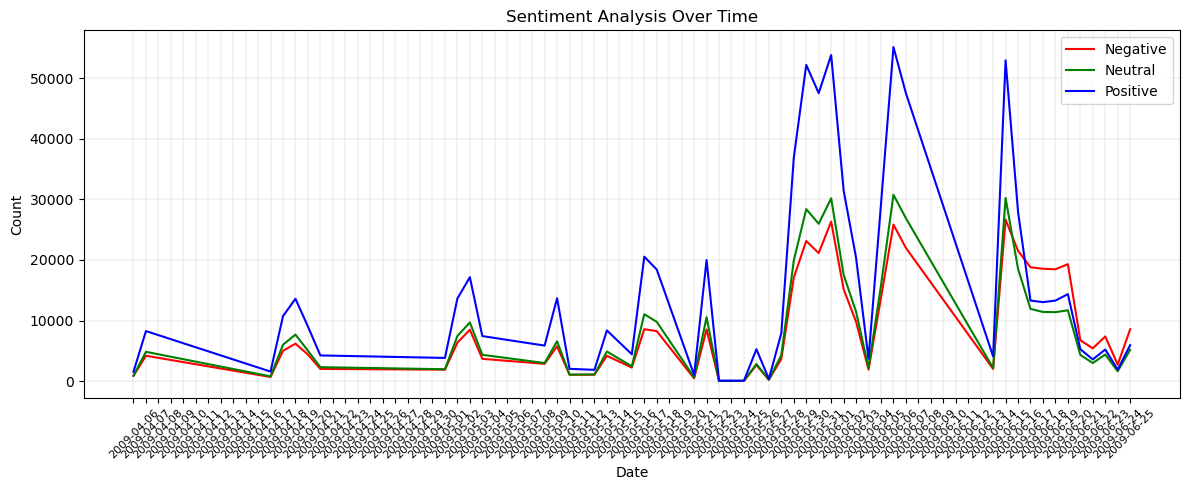

In [142]:
# Plotting a ScatterPlot 

plt.figure(figsize=(12, 5))
plt.plot(full_data['date'], full_data['negative'], label='Negative', color='red')
plt.plot(full_data['date'], full_data['neutral'], label='Neutral', color='green')
plt.plot(full_data['date'], full_data['positive'], label='Positive', color='blue')
plt.xticks(full_data['date'],  rotation=45,fontsize=8) 
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Analysis Over Time')
plt.grid(True, linewidth=0.2)
plt.tight_layout()
plt.legend()
plt.show()

***Autocorrelation***

Autocorrelation refers to the degree of correlation of the same variables between two successive time intervals. It measures how the lagged version of the value of a variable is related to the original version of it in a time series.

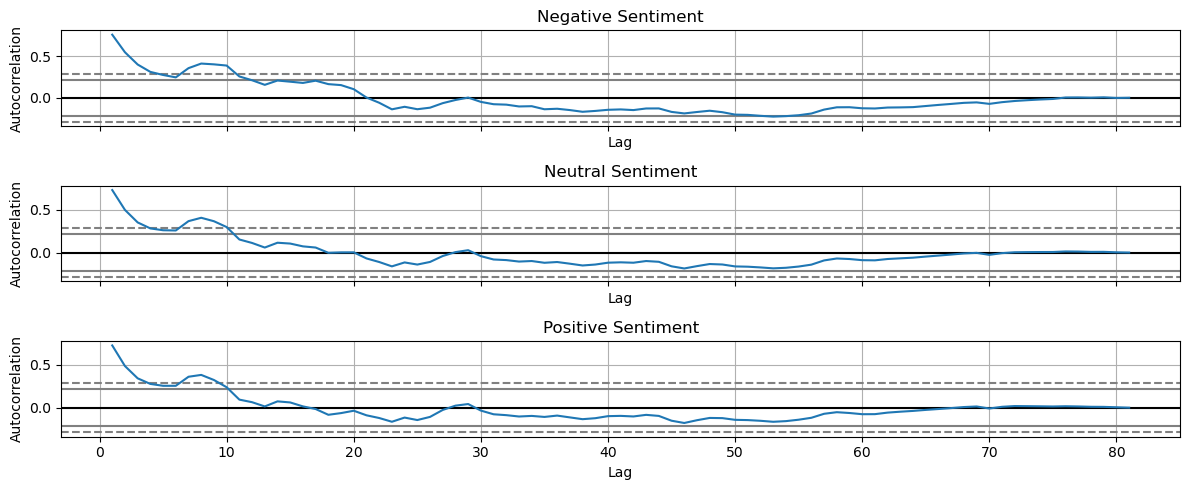

In [97]:
from pandas.plotting import autocorrelation_plot
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(12, 5))  

autocorrelation_plot(full_data['negative'], ax=axs[0])  
autocorrelation_plot(full_data['neutral'], ax=axs[1])  
autocorrelation_plot(full_data['positive'], ax=axs[2])  
axs[0].set_title('Negative Sentiment')  
axs[1].set_title('Neutral Sentiment')  
axs[2].set_title('Positive Sentiment') 
plt.xlabel('Lag')  # Add label for x-axis
plt.ylabel('Autocorrelation')  # Add label for y-axis
plt.tight_layout()  # Adjust spacing between subplots
plt.show()



In this specific plot, the y-axis goes from 0 to 0.5, and the x-axis goes from 0 to around 80 lags. All three lines start at 1 and then decline gradually as the lag increases. This means that the sentiment of a data point is most similar to the sentiment of the previous data point (lag of 1), and the similarity weakens as we look at data points further and further in the past.


    Positive sentiment: The autocorrelation for positive sentiment seems to decay a little faster than the other two categories. This suggests that positive sentiment might be less persistent over time compared to neutral or negative sentiment. In other words, positive sentiment is more likely to fluctuate than negative or neutral sentiment.
    Neutral sentiment: The autocorrelation for neutral sentiment appears to be in the middle, decaying slower than positive sentiment but faster than negative sentiment. This could indicate that neutral sentiment has a somewhat moderate persistence over time.
    Negative sentiment: The autocorrelation for negative sentiment seems to decay the slowest among the three categories. This suggests that negative sentiment might be the most persistent sentiment, meaning negative sentiment tends to persist for a longer period of time. There could be a carry-over effect where a negative event might influence sentiment for a while.

### Decomposition 

Decomposition is a statistical technique that involves breaking down a time series into its underlying components to better understand its patterns and improve forecasting accuracy. The most common components of a time series are trend, seasonality, and remainder.

Decompose - Negative Sentiment


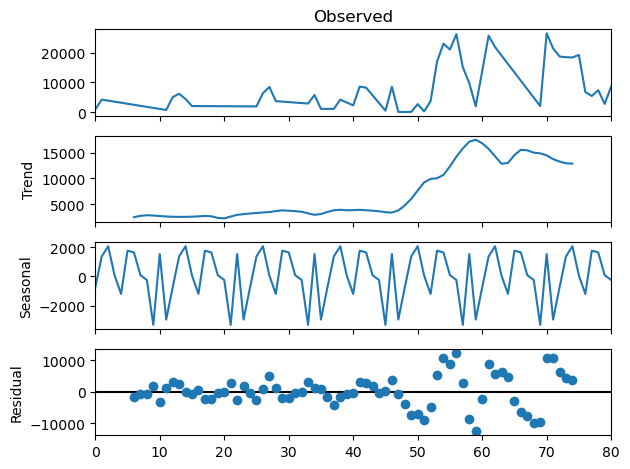

In [260]:
print('Decompose - Negative Sentiment') 

decomposition=seasonal_decompose(negative,model='additive',period=12)
decomposition.plot()
plt.show()

Decompose - Neutral Sentiment


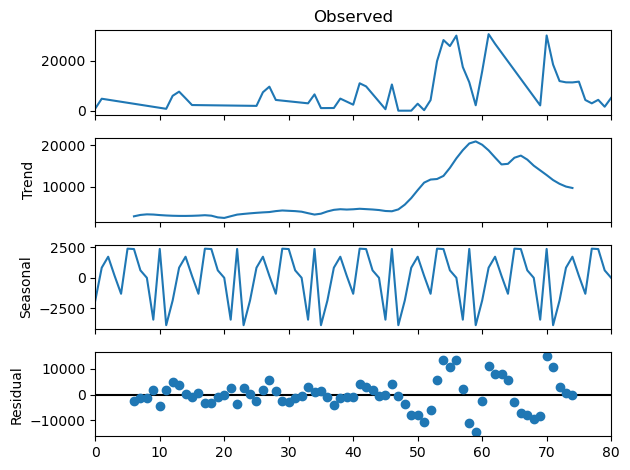

In [259]:
print('Decompose - Neutral Sentiment') 

decomposition=seasonal_decompose(neutral,model='additive',period=12)
decomposition.plot()
plt.show()

Decompose - Positive Sentiment


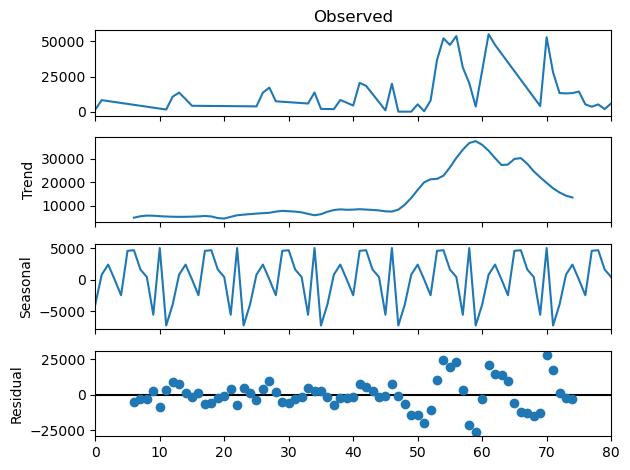

In [258]:
print('Decompose - Positive Sentiment') 


decomposition=seasonal_decompose(positive,model='additive',period=12)
decomposition.plot()
plt.show()

## Applying ARIMA

***Performing the Seasonal ARIMA***

In order to use SARIMA, it is necessary to choose the best "p,d,q" values for the ARIMA, and "P,D,Q" values for the Seasonal component. There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting.

### Hyperparameter

For this project, Randomized Search Cross-Validation was chosen because, while GridSearchCV can be effective, RS-CV offers a good balance between exploration and efficiency, making it a suitable choice for this scenario.

In [230]:
# Define parameter distributions for the search
param_distributions = {
    'order': [(1, 0, 0), (1, 1, 0), (2, 1, 0)],  # ARIMA order
    'seasonal_order': [(1, 0, 1, 12), (1, 1, 1, 12), (2, 1, 1, 12)],  # Seasonal order (adjust if not seasonal)
}

# Create a SARIMA model instance (without fitting yet)
model = auto_arima(positive, suppress_warnings=True)

# Set up RandomizedSearchCV with the SARIMA model and parameter distributions
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, scoring='neg_mean_squared_error', cv=5, n_iter=10)

# Fit the RandomizedSearchCV
grid_search.fit(data)

# Print the best model and its parameters
print(f"Best Model for {sentiment} Sentiment: {grid_search.best_estimator_}")
print(f"Best Parameters for {sentiment}: {grid_search.best_params_}")



Best Model for <function sentiment at 0xffff61d0d1c0> Sentiment:  ARIMA(1,0,0)(1,0,1)[12]          
Best Parameters for <function sentiment at 0xffff61d0d1c0>: {'seasonal_order': (1, 0, 1, 12), 'order': (1, 0, 0)}


In [217]:
from pmdarima import auto_arima

# Assuming 'full_data' is a dictionary and 'negative' is the time series
negative_data = full_data['neutral']

# Fit an ARIMA model with trace enabled (optional)
model = auto_arima(negative_data, trace=True)  # Optional: Prints details during fitting

# Look for indications of stationarity in the printed output
# (pmdarima might suggest differencing if data is non-stationary)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1617.917, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1619.639, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1619.542, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1615.930, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds


In [222]:
from pmdarima import auto_arima

# Assuming 'full_data' is a dictionary and 'negative' is the time series
negative_data = full_data['neutral']

# Fit a non-seasonal ARIMA model with trace enabled (optional)
model_negative = auto_arima(negative_data, seasonal=False, trace=True)  # Optional


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1617.917, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1619.639, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1619.542, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1615.930, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds


In [219]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'full_data' is a dictionary and 'negative' is the time series
negative_data = full_data['neutral']

# Perform the ADF test
adf_result = adfuller(negative_data)

# Print the test statistic, p-value, etc.
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Interpret the results based on significance level (e.g., alpha=0.05)


ADF Statistic: -3.4975861883871233
p-value: 0.008049302688698655


In [213]:

model_negative=pmd.auto_arima(full_data['negative'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Best Model:


ARIMA(1,0,0)(0,0,0)[12] intercept. This indicates that the model with:

    p = 1 (one autoregressive term)
    d = 0 (no differencing needed)
    q = 0 (no moving average term)
    P = 0, D = 0, Q = 0 (not applicable for seasonal data)
    m = 12 (seasonality period of 12)
    Intercept (included)
    Minimizes the AIC value among the explored models.

In [204]:
model_positive=pmd.auto_arima(full_data['positive'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1713.064, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1716.630, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1716.539, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1711.072, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1714.766, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1714.851, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1714.397, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1714.712, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1714.544, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.066 seconds


Best Model:

    ARIMA(0,1,0)(0,0,0)[12] as the "Best model.":
        p = 0 (no autoregressive terms)
        d = 1 (one differencing needed)
        q = 0 (no moving average terms)
        P = 0, D = 0, Q = 0 (not applicable for seasonal data)
        m = 12 (seasonality period of 12)
        No intercept term included

In [205]:
model_neutral=pmd.auto_arima(full_data['neutral'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1617.917, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1621.602, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1621.540, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1615.930, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1619.733, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1619.783, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1619.675, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1619.639, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1619.542, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.886 seconds


Best Model: 
    
    ARIMA(0,1,0)(0,0,0)[12] as the "Best model":

    p = 0 (no autoregressive terms)
    d = 1 (one differencing needed to achieve stationarity)
    q = 0 (no moving average terms)
    P = 0, D = 0, Q = 0 (not applicable for seasonal data)
    m = 12 (seasonality period of 12)

### Now that the best values for  p,d,q wer given,  a ARIMA model will be settled up with these hyperparameters

In [202]:
negative = full_data['negative'].values
positive = full_data['positive'].values
neutral = full_data['neutral'].values


# Define the ARIMA model with best hyperparameters
model_negative = ARIMA(negative, order=(1, 0, 0), seasonal_order=(0, 0, 0, 12))
model_positive = ARIMA(neutral, order=(1, 1, 0), seasonal_order=(0, 0, 0, 12))
model_neutral = ARIMA(negative, order=(1, 1, 0), seasonal_order=(0, 0, 0, 12))



def forecast(models, steps):
    # Fit the model to the data
    model_fit = models.fit()
    result = model_fit.forecast(steps=steps)
    return result


models = [model_negative,model_positive,model_neutral]
for model in models:
    # Forecast for the next 7 days (steps=7)
    result = forecast(model,3)

    # Print the forecast values
    print("Forecast for the next 7 days:")
    print(result)


Forecast for the next 7 days:
[8173.35769505 7874.33105452 7648.89637286]
Forecast for the next 7 days:
[4970.29165546 4982.93850172 4982.18301558]
Forecast for the next 7 days:
[8253.42156475 8270.60344469 8269.67092066]


# Dinamic Dashboard

In [408]:
import dash
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc
import plotly.express as px
from dash.dependencies import Input, Output
import pandas as pd
import plotly.tools as tls



# Convert matplotlib figure to Plotly figure
#plotly_dist_rev_len = tls.mpl_to_plotly(plt)


app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])


# styling the sidebar
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}


# padding for the page content
CONTENT_STYLE = {
    'margin-left': '16rem',
    'margin-right':'2rem',
    'padding': '2rem 1rem',
}

border_style = {
    'width': '400',
    'height': '400',
    'margin': '20px',
    'border-radi    us': '10px',
    'box-shadow': '1 2px 12px rgba(0, 0, 0, 0.2)',
    'border': '2px solid #ccc'
}


menu_style = {
    'textAlign': 'center',
    'font-family': 'Arial',
    'font-weight': 'bold',
    'font-size': '26px',
    'color': '#2196F3',
    'margin': '20px',
    
}



title_style = {
    'textAlign': 'left',
    'font-family': 'Arial',
    'font-weight': 'bold',
    'font-size': '18px',
    'color': '#2196F3',
    'margin': '20px',
    
}
space_style = {
    'height': '200px',
    'border-radius': '10px',
    'box-shadow': '0 2px 12px rgba(0, 0, 0, 0.2)'
}


header_style = {
    'textAlign': 'right',
    'font-family': 'Roboto, sans-serif',
    'font-weight': 'bold',
    'font-size': '14px',
    'color': '#2196F3',
    #'text-transform': 'uppercase',
    'letter-spacing': '0.2rem',
    'background-color': "#f8f9fa",
    'padding': '10px 0'
    }


footer_style = {
    'textAlign': 'center',
    'font-family': 'Roboto, sans-serif',
    'font-size': '8',
    'color': '#2196F3',
    'margin-left': '16rem',

    'letter-spacing': '0.2rem',
    'background-color': "#f8f9fa",
    'padding': '10px 0'    
    }



sidebar = html.Div(
    [
        html.H2("Menu", style=menu_style),
        html.Hr(),

        dbc.Nav(
            [
                dbc.NavLink("Bike Stations", href="/", active="exact"),
                dbc.NavLink("Bike Usage", href="/bike_usage", active="exact"),
                dbc.NavLink("Sentiment Analysis", href="/sentiment", active="exact"),

            ],
            vertical=True,
            pills=True),
        html.Hr(),
    ],
    style=SIDEBAR_STYLE,
)

header = html.Div(
    [
        html.H2(
            "Bike Sharing Analysis - Dublin and Washington D.C.",
            
        ),
        html.Hr(style={'width': '60%', 'border-color': '#ccc'}),
    ], style=header_style,)





content = html.Div(id="page-content", children=[], style=CONTENT_STYLE)



footer = html.Div(
    [
        html.P("Jose Mario Costa  |  www.jmcloudpro.com  |  https://github.com/jmdtanalyst/", style=footer_style)
        
    ], )

app.layout = html.Div([
    dcc.Location(id="url"),
    header,
    sidebar,
    content,
    footer
            

])


@app.callback(
    Output("page-content", "children"),
    [Input("url", "pathname")]
)
def render_page_content(pathname):
    if pathname == "/":
        
        
        return [
                html.H4('Bike Stations Analysis', style=title_style),
                dcc.Graph(id="dublin_map", figure=dublin_map, style=border_style),
                dcc.Graph(id="top_10_dublin", figure=top_10_dublin, style=border_style),
                dcc.Graph(id="capital_map", figure=capital_map, style=border_style),
                dcc.Graph(id="top_10_capital", figure=top_10_capital, style=border_style)
                ]


        
        
    elif pathname == "/bike_usage":
        return [
                html.H4(' Volume of trips by Weekdays', style=title_style),

                dcc.Graph(id="bike_usage_weekday", figure=bike_usage_weekday, style=border_style),
                html.H4(' Volume of trips by Month', style=title_style),

            dcc.Graph(id="bike_usage_by_month", figure=bike_usage_by_month, style=border_style),
                ]
    elif pathname == "/sentiment":
        return [
                html.H1('Sentiment Analysis - TextBlob', style=title_style),
                dcc.Graph(id="scatter_polarity", figure=scatter_polarity, style=border_style),  
                dcc.Graph(id="sentiment_dist2", figure=sentiment_dist, style=border_style), 
                dcc.Graph(id="sentiment_dist", figure=plotly_dist_rev_len, style=border_style),  

                ]
    
    
    # If the user tries to reach a different page, return a 404 message
    return dbc.Jumbotron(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ]
    )


if __name__=='__main__':
    app.run_server(debug=True, port=8050)